In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
def plot_purity(results_raw, results_topo):
    timeline = np.arange(len(results_raw))
    print('Results raw - ACC kmeans', np.mean([i[0][0] for i in results_raw]))
    print('Results raw - ACC argmax Q', np.mean([i[0][1] for i in results_raw]))
    print('Results topo - ACC kmeans',np.mean([i[0][0] for i in results_topo]))
    print('Results topo - ACC argmax Q',np.mean([i[0][1] for i in results_topo]))

    # Create a single chart with all four line plots
    plt.plot(timeline, [i[0][0] for i in results_raw], label='GEC - kmeans', linestyle="--",color='#FF856B',marker='.')
    plt.plot(timeline, [i[0][1] for i in results_raw], label='GEC - argmax Q',linestyle="--",color='#00C8F4',marker='.')
    plt.plot(timeline, [i[0][0] for i in results_topo], label='Topo - kmeans',linestyle="-",color='#C34A36',marker='.')
    plt.plot(timeline, [i[0][1] for i in results_topo], label='Topo - argmax Q',linestyle="-",color='#005C86',marker='.')
    plt.xlabel('Timeline')
    plt.ylabel('ACC')
    plt.legend(loc="upper right")
    plt.show()

def plot_metrics(results_raw, results_topo):
    timeline = np.arange(len(results_raw))
    print('Results raw - ARI', np.mean([i[1] for i in results_raw]))
    print('Results raw - NMI', np.mean([i[2] for i in results_raw]))
    print('Results topo - ARI',np.mean([i[1] for i in results_topo]))
    print('Results topo - NMI',np.mean([i[2] for i in results_topo]))
    # Create a single chart with all four line plots
    plt.plot(timeline, [i[1] for i in results_raw], label='GAEC - ARI',linestyle="--",color='#FF856B',marker='.')
    plt.plot(timeline, [i[2] for i in results_raw], label='GAEC - NMI',linestyle="--",color='#00C8F4',marker='.')
    plt.plot(timeline, [i[1] for i in results_topo], label='Topo - ARI',linestyle="-",color='#C34A36',marker='.')
    plt.plot(timeline, [i[2] for i in results_topo], label='Topo - NMI',linestyle="-",color='#005C86',marker='.')
    plt.xlabel('Timeline')
    plt.ylabel('NMI and ARI')
    plt.legend(loc="upper right")
    plt.show()

def plot_modularity(results_raw, results_topo):
    timeline = np.arange(len(results_raw))
    # Create a single chart with all four line plots
    print('Modularity raw' , np.mean([i[3][0] for i in results_raw]))
    print('Modularity topo', np.mean([i[3][0] for i in results_topo]))
    print('Modularity truth', np.mean([i[3][1] for i in results_topo]))
    plt.plot(timeline, [i[3][0] for i in results_raw], label='Modularity GAEC',linestyle="--",color='#FF856B',marker='.')
    plt.plot(timeline, [i[3][0] for i in results_topo], label='Modularity Topo',linestyle="-",color='#C34A36',marker='.')
    plt.plot(timeline, [i[3][1] for i in results_topo], label='Modularity Label',linestyle="-.",color='#288400',marker='.')
    plt.xlabel('Timeline')
    plt.ylabel('Modularity')
    plt.legend(loc="upper right")
    plt.show()

In [10]:
import scipy.sparse as sp
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score

def acc(y_pred, y_true):
    """
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1]
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

def modularity(adjacency_matrix:sp.coo_matrix, label_list): 
    S = to_categorical(label_list, num_classes=None)
    # S2 = torch.nn.functional.one_hot(torch.LongTensor(label_list))
    # S = S2.numpy()
    if isinstance(adjacency_matrix, torch.Tensor):
        A = adjacency_matrix.cpu().numpy()
    elif isinstance(adjacency_matrix, np.ndarray):
        A = adjacency_matrix
    else:
        A = adjacency_matrix.toarray()
    m = np.sum(A) / 2
    k = np.sum(A, axis=1)
    B = A - np.outer(k, k) / (2 * m)
    Q = 1 / (2 * m) * np.trace(np.dot(np.dot(S.T, B), S))
    return Q 

In [15]:
import pickle
import os
from sklearn.cluster import KMeans
from sklearn import metrics
base = "./"
label_num_dic = {"Cora": 10,"enron":7,"highschool":9,"DBLP":15,"DBLPdyn":14}
def load_data(name):
    with open(os.path.join(base+ name, 'results_raw.pkl'), 'rb') as handle:
        try:
            data_raw = pickle.load(handle, encoding='bytes', fix_imports=True)
        except ValueError:
            handle.seek(0)
            data_raw = pickle.load(handle, encoding='bytes', fix_imports=True, protocol=2)
    with open(os.path.join(base+ name, 'results_topo.pkl'), 'rb') as handle:
        try:
            data_topo = pickle.load(handle, encoding='bytes', fix_imports=True)
        except ValueError:
            handle.seek(0)
            data_topo = pickle.load(handle, encoding='bytes', fix_imports=True, protocol=2)
    print(len(data_raw),len(data_topo))
    return data_raw, data_topo
def main(name):
    n_cluster = label_num_dic[name]
    results_raw = []
    results_topo = []
    data_raw, data_topo = load_data(name=name)
    for z,q,adj,labels in data_raw: #darray darray cor_matrix list
        _results_tmp = []
        for _ in range(5):
            # k-means
            cluster_model = KMeans(n_clusters=n_cluster,n_init=20)
            cluster_model.fit(z)
            cluster_labels = cluster_model.labels_
            # cluster_labels =np.argmax(q,axis=1)
            # print(max(cluster_labels))
            _results_tmp.append([
                acc(cluster_labels,labels),
                acc(np.argmax(q,axis=1), labels), 
                metrics.adjusted_rand_score(cluster_labels, labels), # ARI
                metrics.normalized_mutual_info_score(cluster_labels, labels), #NMI
                modularity(adj,cluster_labels),modularity(adj,labels),
            ])
        _results_tmp = np.mean(_results_tmp,axis = 0)
        results_raw.append([
                (_results_tmp[0],
                _results_tmp[1]), 
                _results_tmp[2], # ARI
                _results_tmp[3], #NMI
                (_results_tmp[4],_results_tmp[5]),
            ])
    for z,q,adj,labels in data_topo: #darray darray cor_matrix list
        _results_tmp = []
        for _ in range(5):
            cluster_model = KMeans(n_clusters=n_cluster,n_init=20)
            cluster_model.fit(z)
            cluster_labels = cluster_model.labels_
            # cluster_labels = np.argmax(q,axis=1)
            # print(max(cluster_labels))
            _results_tmp.append([
                acc(cluster_labels,labels),
                acc(np.argmax(q,axis=1), labels), 
                metrics.adjusted_rand_score(cluster_labels, labels), #ARI
                metrics.normalized_mutual_info_score(cluster_labels, labels), #NMI
                modularity(adj,cluster_labels),modularity(adj,labels),
            ])
        _results_tmp = np.mean(_results_tmp,axis = 0)

        results_topo.append([
                (_results_tmp[0],
                _results_tmp[1]), 
                _results_tmp[2], # ARI
                _results_tmp[3], #NMI
                (_results_tmp[4],_results_tmp[5]),
            ])
    # results_topo = [results_raw[0]] + results_topo + [results_raw[-1]] # alignment
    plot_purity(results_raw, results_topo)
    plot_metrics(results_raw, results_topo)
    plot_modularity(results_raw, results_topo)

15 15
Results raw - ACC kmeans 0.5858212513668858
Results raw - ACC argmax Q 0.5718548212842861
Results topo - ACC kmeans 0.5898067992207224
Results topo - ACC argmax Q 0.5696346723718589


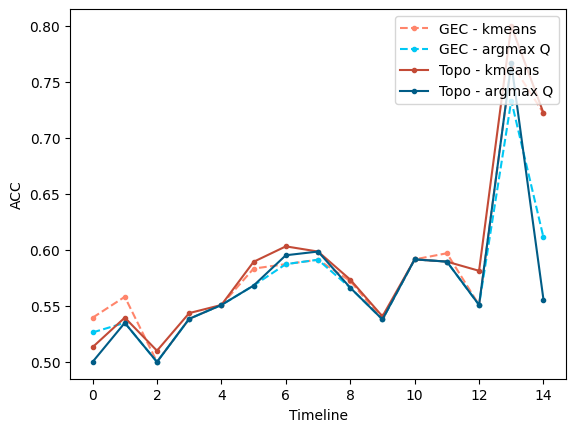

Results raw - ARI 0.011284488152306954
Results raw - NMI 0.159997821071582
Results topo - ARI 0.019825055902878766
Results topo - NMI 0.18739512820031243


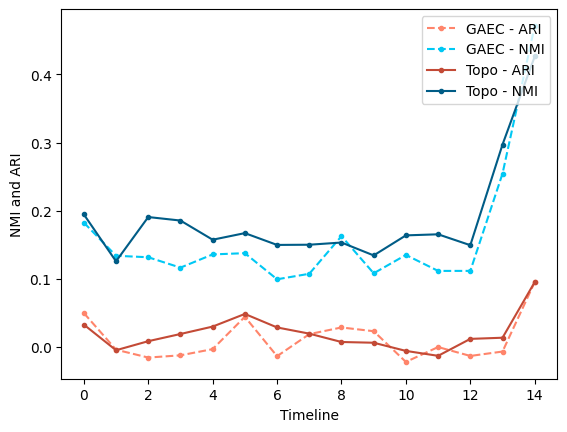

Modularity raw 0.3159591403326978
Modularity topo 0.4047434691374256
Modularity truth 0.05558799417575444


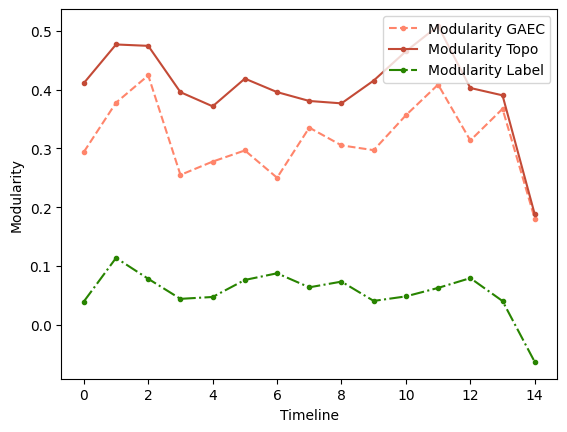

In [16]:
main("enron")

50 50
Results raw - ACC kmeans 0.37528043333961314
Results raw - ACC argmax Q 0.3569280527609831
Results topo - ACC kmeans 0.6244539221344503
Results topo - ACC argmax Q 0.40421102145895466


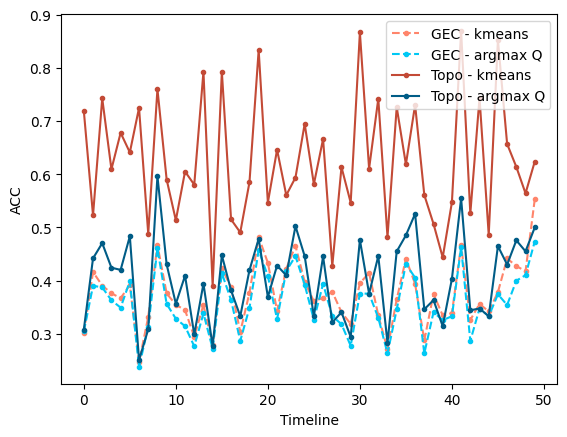

Results raw - ARI 0.13772011234960485
Results raw - NMI 0.2813668729498058
Results topo - ARI 0.4089205604131092
Results topo - NMI 0.5668021262897535


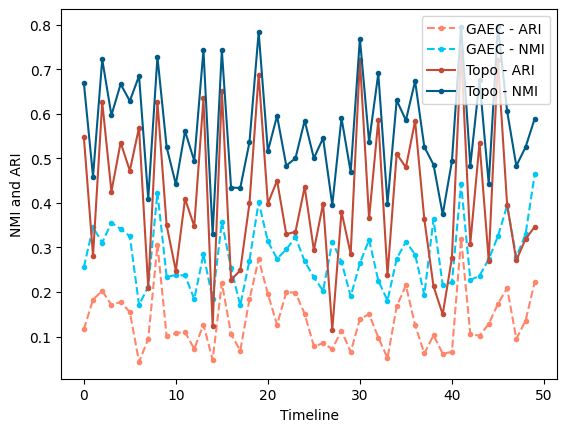

Modularity raw 0.49838827009500536
Modularity topo 0.719973422973288
Modularity truth 0.7362154619820968


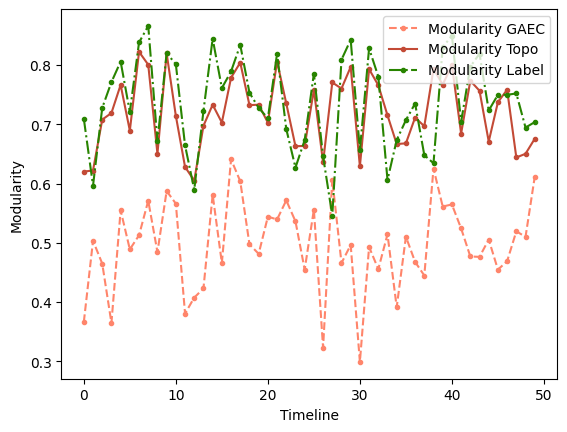

In [17]:
main("highschool")

10 10
Results raw - ACC kmeans 0.39048800342097495
Results raw - ACC argmax Q 0.38944447086372047
Results topo - ACC kmeans 0.42419844066142287
Results topo - ACC argmax Q 0.3902790952641171


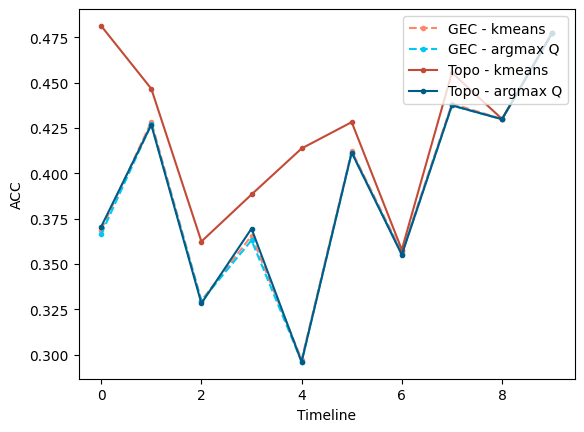

Results raw - ARI 0.004219989547026372
Results raw - NMI 0.023451045766835585
Results topo - ARI 0.023649887047928125
Results topo - NMI 0.0842945313978822


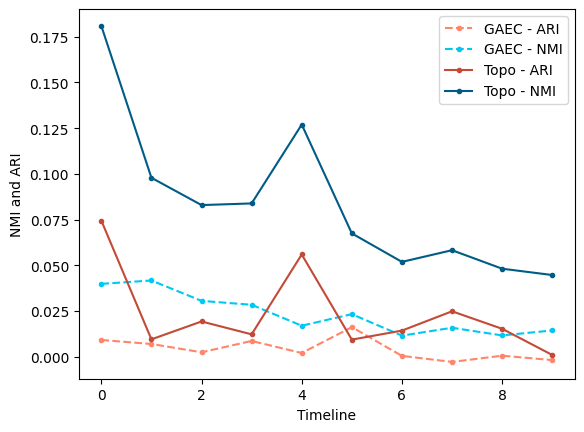

Modularity raw 0.6146724411582117
Modularity topo 0.8389779415192662
Modularity truth 0.6546759402480373


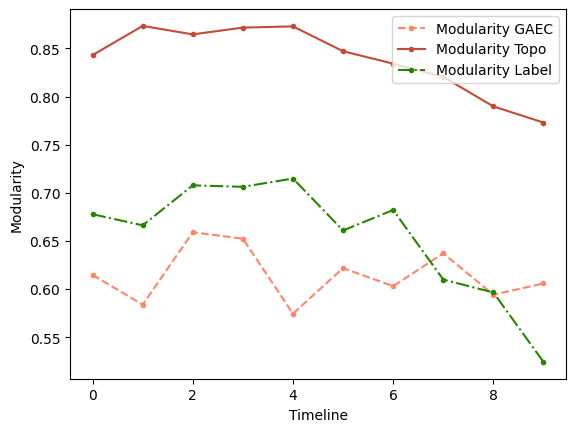

In [18]:
main("DBLP")

11 11
Results raw - ACC kmeans 0.35129528793875087
Results raw - ACC argmax Q 0.3493926931437797
Results topo - ACC kmeans 0.4821862303248936
Results topo - ACC argmax Q 0.3982187308281064


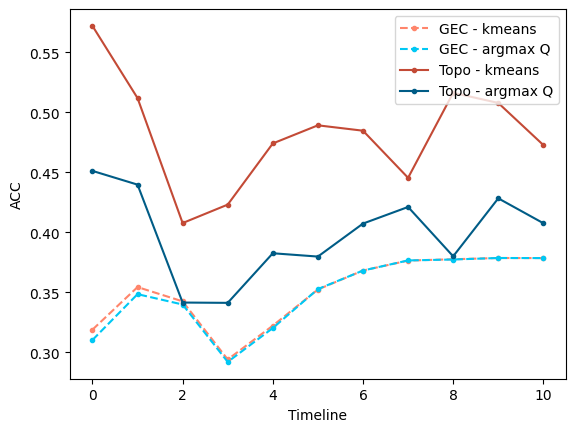

Results raw - ARI 0.012143731442670697
Results raw - NMI 0.03405860477714668
Results topo - ARI 0.11513227010346627
Results topo - NMI 0.201166645106868


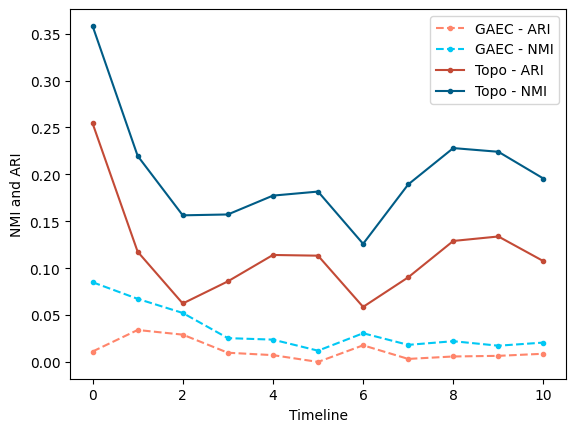

Modularity raw 0.42663218797146596
Modularity topo 0.6827367379193849
Modularity truth 0.5652609641941679


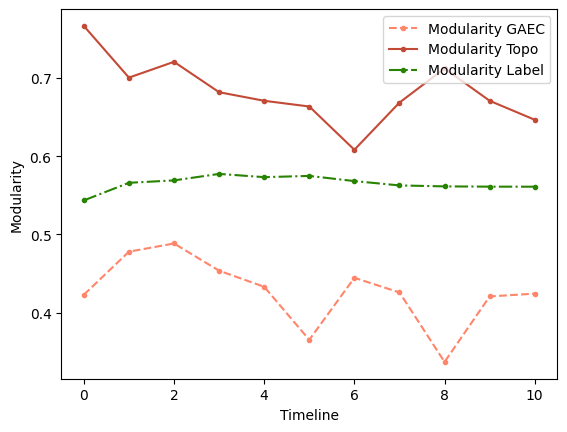

In [19]:
main("Cora")